#  <span style="color:orange">Style transfer using image segmentation </span>

<a href="https://colab.research.google.com/github/datarootsio/style-transfer-workshop/blob/main/notebooks/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Do you want to restyle or redesign your interior, but don't want to leave the comfort of your own home? Don't fancy reading through hundreds of interior design albums or going to your local furniture store to try imagining those couches in your own living room? Have you always dreamed of a couch with an extravagant tiger print, but you don't know if it will fit your interior? 

**Style transfer is the right thing for you!**

# 1 Tutorial objectives

This tutorial will show you how to apply style transfer to a picture using image segmentation.

If you want to discover the final AI-driven application which allows you to add different colors or patterns to an image, you can check [this link](https://huggingface.co/spaces/dataroots/SofaStyler). The app is available through our HuggingFace Space.

We use Colab for the ease of the demo, we do not advise to build your style transfer application within a notebook. The goal is to have a visual easy to follow tutorial to understand how to apply style transfer to an image.

<span style="color:red">IMPORTANT INSTRUCTIONS: </span>
Please make a copy of this notebook, upload it into your own google drive.

If you decided to open this notebook without cloning the entire GitHub repository, please make sure to upload all the needed files manually. 

![Maintainer](https://dataroots.io/maintained-rnd.svg)

## 1.1 Prerequisites

This tutorial is tested using Python 3.7.13. Please check that you have the right version of python installed on your current environment using the following command:

In [ ]:
!python --version

Python 3.7.13


To accelerate graphics rendering, we need to select GPU as hardware accelerator. To do that, you can go to:

Menu --> Runtime --> Change runtime type --> Select "GPU" for the hardware accelerator 

## 1.2 Target audience

The target for this tutorial is young graduates or master students with a background in Python and AI. 

## 1.3 Install useful packages

We need to install a specific version for each python packages that will be used in this tutorial. We first pipe all these useful packages into a requirements.txt file before installing them. This step can take several minutes to run.

In [ ]:
!printf 'opencv-python \nopencv-contrib-python \ntorch==1.8.0 \ntorchvision==0.9.0 \npillow \nnumpy \nscipy \ntqdm \nmatplotlib \nipykernel \nazureml-core \nazureml-dataprep \ntensorflow==2.2 \nkeras==2.3.1 \nazure-cli' > requirements.txt

In [ ]:
!pip install -q -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install -q -U segmentation-models

     |████████████████████████████████| 48.3 MB 1.2 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 


In [ ]:
!pip install -q -r requirements.txt

     |████████████████████████████████| 735.5 MB 13 kB/s 
     |████████████████████████████████| 17.3 MB 94 kB/s 
     |████████████████████████████████| 2.7 MB 43.4 MB/s 
     |████████████████████████████████| 43.4 MB 1.8 kB/s 
     |████████████████████████████████| 516.2 MB 4.3 kB/s 
     |████████████████████████████████| 377 kB 47.1 MB/s 
     |████████████████████████████████| 2.5 MB 59.0 MB/s 
     |████████████████████████████████| 3.0 MB 31.1 MB/s 
     |████████████████████████████████| 454 kB 54.5 MB/s 
     |████████████████████████████████| 2.9 MB 32.0 MB/s 
     |████████████████████████████████| 59 kB 5.4 MB/s 
     |████████████████████████████████| 1.8 MB 55.3 MB/s 
     |████████████████████████████████| 1.2 MB 37.7 MB/s 
     |████████████████████████████████| 4.1 MB 44.2 MB/s 
     |████████████████████████████████| 2.0 MB 48.9 MB/s 
     |████████████████████████████████| 178 kB 49.1 MB/s 
     |████████████████████████████████| 489 kB 33.1 MB/s 
     |██████████

In [ ]:
# restart the runtime to be sure that all packages are correctly installed
import os
os.kill(os.getpid(), 9)

In [ ]:
# Allow GPU instance to run the code
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# 2 Dataset used for the tutorial

Before we can even start training any machine learning model, we need good training data. In this case, we need good labeled data for training the segmentation model (that will be explained in the next section). Labelling images for image segmentation requires to construct masks; color-coded pixel-by-pixel areas which distinguish one object from another. Creating such masks is a very time-intensive venture. So rather than constructing a database ourselves, we searched for an existing dataset.

We used the [3D-FUTURE: 3D FUrniture shape with TextURE dataset](https://tianchi.aliyun.com/specials/promotion/alibaba-3d-future) created by Fu et al., 2021, available upon request from Alibaba Cloud. This dataset contains 20 240 images of virtual indoor spaces, of which approximately 10 000 contain a sofa. That is why we decided to use the sofa as furniture to apply style transfer.


## 2.1 Which types of data do we have?

In the dataset that we downloaded, we can find several types of data:
- **train**: data that will be used to train the image segmentation model
- **test**: data that will be used to evaluate the performance of the trained image segmentation model
- **validation**: data that will be used to fine-tune the image segmentation model, i.e. find the best parameters to use in the model

We have created a folder for each of these data categories. It's important to mention that each folder contains itself 2 other folders, namely:
- **image**: original picture of a virtual indoor space
- **idmap**: color coded image that segment all furniture objects in the image

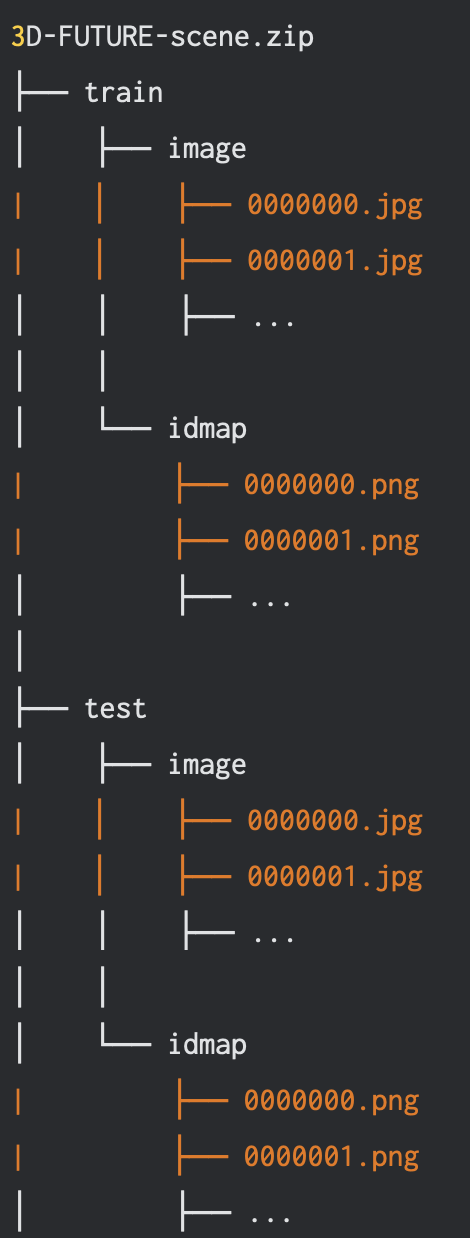

## 2.2 Connect to Azure Blob

For ease of access, we have stored the data in the cloud (Azure). 
Before being able to access data from an Azure Blob storage, you first need to login into Azure using the following command. 

Please click on the link that appears after having ran the cell and enter the code to be able to login with your personnal account. 

In [ ]:
!az login

Now that you are connected to Azure with your personnal account, you can access the Blob containing the data for this tutorial.

In [48]:
import azureml.core
from azureml.core import Workspace

ws = Workspace.from_config('./config.json')
default_ds = ws.get_default_datastore()
print('Ready to use Azure ML {} to work with {} (datastore = {})'.format(
        azureml.core.VERSION, ws.name,default_ds.name))
ds = ws.datasets['all']
mount_ds = ds.mount()
ds_mount_folder = mount_ds.mount_point

mount_ds.start()

DATA_DIR = ds_mount_folder
print("You have access to the Azure Blob!")

Ready to use Azure ML 1.43.0 to work with ml-homedesign (datastore = images_data)
Volume mount is not enabled. 
Falling back to dataflow mount.
You have access to the Azure Blob!


## 2.3 Download some data from Azure

Let's now retrieve some data from the Azure Blob Storage we are connected to

In [55]:
# Create path to data
import os
x_train_dir = os.path.join(DATA_DIR, 'train/image')
y_train_dir = os.path.join(DATA_DIR, 'train/masks')

x_valid_dir = os.path.join(DATA_DIR, 'validation/image')
y_valid_dir = os.path.join(DATA_DIR, 'validation/masks')

x_test_dir = os.path.join(DATA_DIR, 'test/image')
y_test_dir = os.path.join(DATA_DIR, 'test/masks')

width,length = 1184,1184

In [ ]:
!pip uninstall opencv-python --yes
!pip install opencv-python

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.9 MB 78 kB/s 


In this section, we will create 2 classes to manage data:
- **Dataset**: This class is used to read images in the cloud, apply image augmentation in order to get more data and apply preprocessing transformations on this data. 
- **Dataloder**: This class is used to load data from a dataset and form batches. It is this object that will be given as input to the model in order to provide it with data. 

In [56]:
from tensorflow import keras 
import cv2
import numpy as np

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['unlabelled','sofa']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = [image_id for image_id in os.listdir(masks_dir) if '.png' in image_id]
        self.images_fps = [os.path.join(images_dir, image_id).replace('.png','.jpg') for image_id in self.ids] #.replace('.png','.jpg')
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.resize(image,(1184,1184), interpolation=cv2.INTER_CUBIC)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask,(1184,1184), interpolation=cv2.INTER_CUBIC)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids) 

In [57]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []

        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch) 
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)  

In [58]:
# Create dataset with our data - Virtual inside space pictures containing a sofa
original_dataset = Dataset(x_valid_dir, y_valid_dir, classes=['sofa'])
print("Length of the original validation dataset: ", len(original_dataset))

## 2.4 Look at some examples (images and masks)

For having a better idea of the images we are using, let's look at 5 examples. We observe that the mask correctly highlights the sofa on each picture.
Sometimes the mask highlights a chair instead of a sofa. 

In [59]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap='gray')
    plt.show()

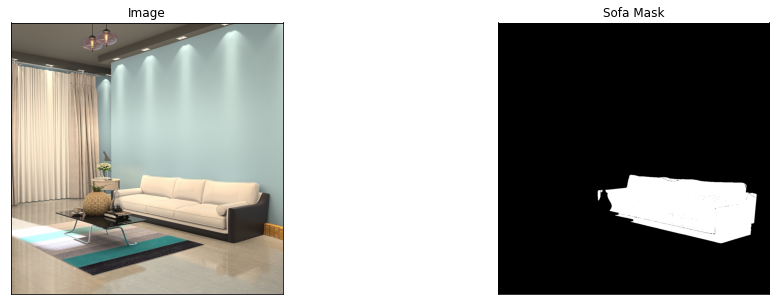

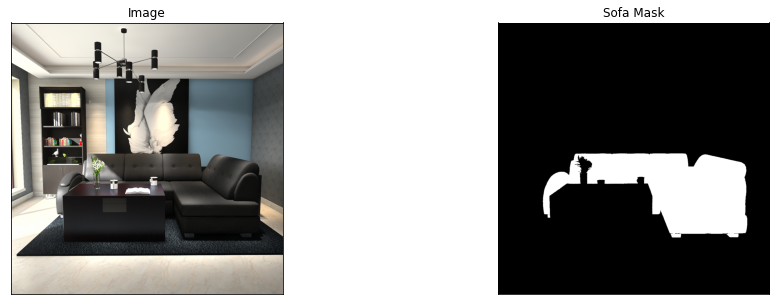

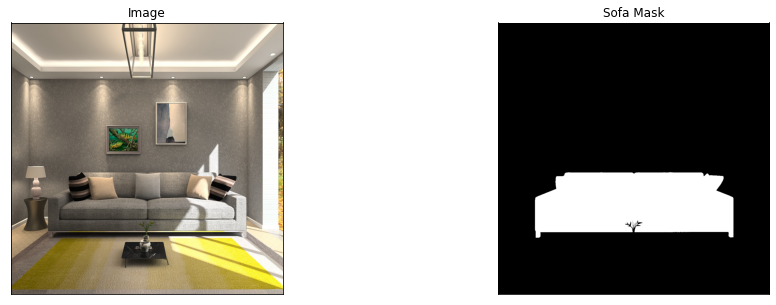

In [60]:
for i in range(3):
  image, mask = original_dataset[i] # get some samples
  visualize(
      image=image, 
      sofa_mask=mask[..., 0].squeeze(),
  )

# 3 Using image segmentation - Detect a sofa in your livingroom

Image segmentation is really helpful to detect objects on an image. In our case, we need to be able to detect a sofa in a livingroom's virtual picture. The final goal of this section is to create a model which is able to discover a sofa on unseen data, so that we could apply image segmentation to new pictures. 

## 3.1 What is image segmentation

Image segmentation is the process of dividing an image into different regions based on the characteristics of pixels to identify objects. In other words, image segmentation is a computer vision algorithm that assigns label to each pixel of an image. All pixels belonging to the same label have a common category assign to them. 

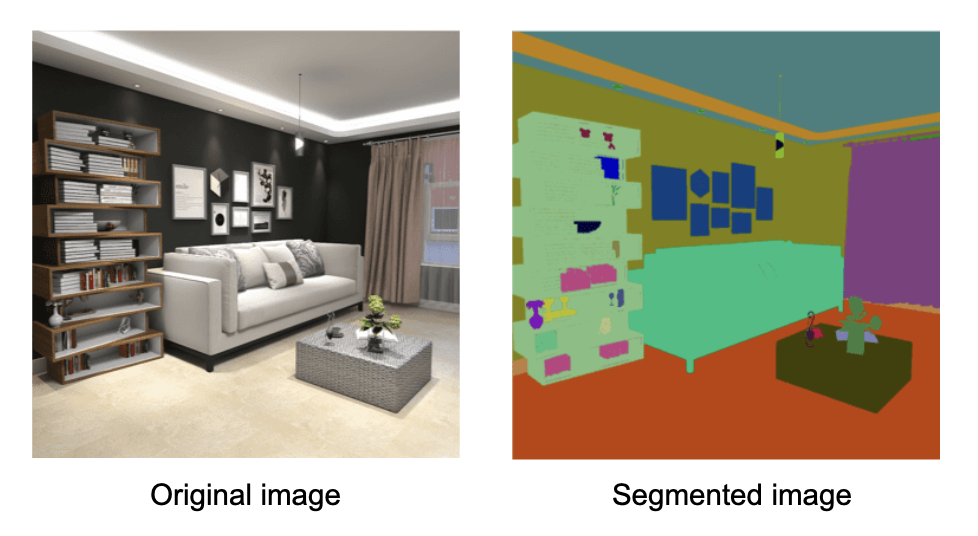

In our case, image segmentation is very useful because we want to transfer a new style to only one particular furniture, not to the entire picture. Therefore, that's important to be able to identify a furniture on a picture.

## 3.2 Why do we need data augmentation?

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting. Since our dataset is very small we will apply a large number of different data augmentation techniques:
- horizontal flip
- affine tranforms 
- perspective transforms
- brightness/contrast/colors manipulations
- image bluring and sharpening
- gaussian noise
- random crops

All these tranformations can be easily applied thanks to a fast augmentation library called [Albumentations](https://github.com/albu/albumentations/).

In [61]:
import albumentations as A

# define heavy augmentations
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)
    
def get_training_augmentation():
    train_transform = [
        
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),
        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(1184, 1184)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform"""
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

### 3.2.1 Effect of data augmentation methods

This data augmentation function may seem difficult to interpret at first. Let's take a look at the effect of some of the transformations that are performed in this function in order to understand it better.

Note: In the following cells, most of the transformations will have a probablility of 1 in order to be sure that the transformation can be observed. In the reallity, this is not the case, the probability of applying a transformation is between 0 and 1.

In [62]:
index = 1
image, _ = original_dataset[index] 

**Horizontal flip of the image**

In this example, the image is flipped horizontally. The input can be flipped either horizontally, vertically or both horizontally and vertically.

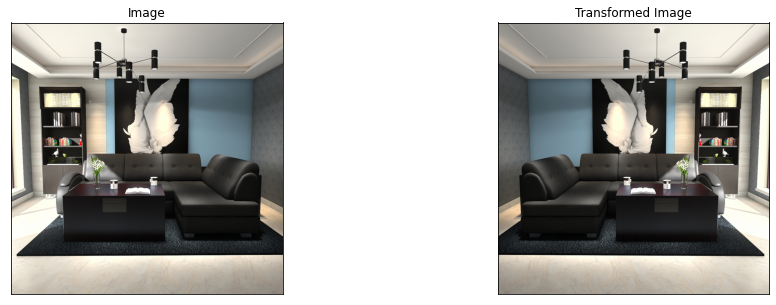

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=1)
])

transformed = transform(image=image)
transformed_image = transformed['image']

visualize(
      image=image, 
      transformed_image=transformed_image,
  )

**Brightness/contrast/colors manipulations**

In the following example, the saturation of the input image is randomly changed.

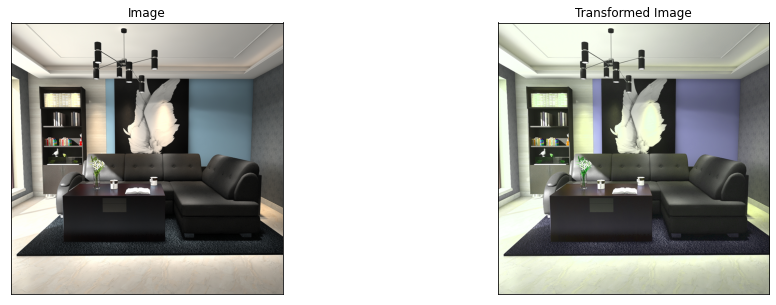

In [64]:
transform = A.Compose([
    A.HueSaturationValue(p=1)
])

transformed = transform(image=image)
transformed_image = transformed['image']

visualize(
      image=image, 
      transformed_image=transformed_image,
  )

**Random crop**

Crop the input image randomly.

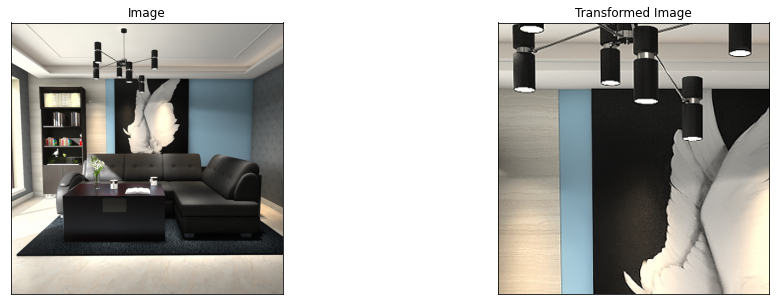

In [ ]:
transform = A.Compose([
    A.RandomCrop(height=320, width=320, always_apply=True)
])

transformed = transform(image=image)
transformed_image = transformed['image']

visualize(
      image=image, 
      transformed_image=transformed_image,
  )

Feel free to try other transformations if you want to see what impact they have on the input image. 

Note: Some transformations apply a change to the pixels of the image that is not visible to the naked eye

### 3.2.2 Look at some examples (images and masks)

Lets look at some augmented data we have created. You observe that augmented images are sub-parts of the original images. This is why you will regularly find augmented images containing a part of a sofa for example. 

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:262: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:385: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1615: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:232: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

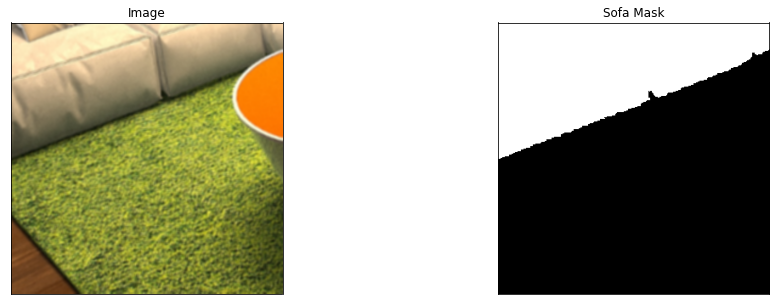

In [ ]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['sofa'], augmentation=get_training_augmentation())

image, mask = dataset[0] # get some sample
visualize(
    image=image, 
    sofa_mask=mask[..., 0].squeeze(),
)

## 3.3 How to train an image segmentation model?

Now that we have enough data, it's time to build an image segmentation model in order to be able to predict the mask on a new picture. 

<span style="color:red">Warning: Training a model from scratch requires a lot of time and computing resources </span>

Fortunately, we already trained a model for you so that you don't need to train a model from scratch again. If you plan to use the trained model, you can directly go to the next section.

The pre-trained image segmentation model that is used here is called Unet. It is one of the most popular approaches used in any segmentation task today. It is a fully convolutional neural network that is designed to learn from fewer training samples. If you want to know more about the architecture of this encoder-decoder model, let's look at [this link](https://medium.com/analytics-vidhya/what-is-unet-157314c87634).

Before building the model in the following code, let's define some important terms:
- **Backbone**: is the architectural element which defines how the layers should be arranged in the encoder network and how the decoder network should be built.
- **Batch size**: defines the number of samples that will be propagated through the network. For example, if you have 100 training samples and a batch size of 20, you will first consider the 20 first samples (from 1st to 20th) and train the model with this batch. Then, you will consider the next 20 samples (from 21th to 40th) and train the model again. We can keep doing this procedure until we have propagated all samples through of the network.
- **Epoch**: One epoch consists of one forward pass and one backward pass of all the training examples
- **LR**: (Learning Rate) is a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function

In [ ]:
import tensorflow as tf

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

# Set parameters
BACKBONE = 'resnet50' 
BATCH_SIZE = 20
CLASSES = ['sofa']
LR = 0.0001
EPOCHS = 2

preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create image segmentation model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
94593024/94592056 [==============================] - 9s 0us/step


Now that we have created the image segmentation model, we need to define the optimizer, loss and metrics that will be computed by this model: 

- **Optimizer**: We chose the Adam optimizer from Keras. Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.
- **Dice loss**: This loss is obtained by calculating smooth dice coefficient function. This loss is the most commonly used loss is segmentation problems.
- **Focal loss**: This loss is an improvement to the standard cross-entropy criterion. This is done by changing its shape such that the loss assigned to well-classified examples is down-weighted. Ultimately, this ensures that there is no class imbalance. 
- **IoU score**: The Intersection over Union (IoU) metric is essentially a method to quantify the percent overlap between the target mask and our prediction output.
- **F-score**: The F-score can be interpreted as a weighted average of the precision and recall


In [ ]:
# define optomizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./checkpoint.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

We need to create a dataset for the training data and another one for the validation data. The validation dataset will be used to fine-tune the parameters during the training of the model.

In [ ]:
IMG_SIZE=320

# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, IMG_SIZE, IMG_SIZE, n_classes)


/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:262: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:385: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1615: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:232: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

The following code starts the training of the model. This is probably the longest part of the tutorial, if you don't want to wait for 3 hours before getting results, you can directly go to the next section.

In [ ]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

history.history

Let's look at the evolution of each metric over the epochs

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 3.4 Performance of segmentation model on unseen data (test dataset)

The pre-trained image segmentation model that is used here is called Unet. It is one of the most popular approaches used in any segmentation task today. It is a fully convolutional neural network that is designed to learn from fewer training samples. If you want to know more about the architecture of this encoder-decoder model, let's look at [this link](https://medium.com/analytics-vidhya/what-is-unet-157314c87634).

Before building the model in the following code, let's define some important terms:
- **Backbone**: is the architectural element which defines how the layers should be arranged in the encoder network and how the decoder network should be built.
- **Batch size**: defines the number of samples that will be propagated through the network. For example, if you have 100 training samples and a batch size of 20, you will first consider the 20 first samples (from 1st to 20th) and train the model with this batch. Then, you will consider the next 20 samples (from 21th to 40th) and train the model again. We can keep doing this procedure until we have propagated all samples through of the network.
- **Epoch**: One epoch consists of one forward pass and one backward pass of all the training examples
- **LR**: (Learning Rate) is a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function

In [ ]:
import tensorflow as tf

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

# Set parameters
BACKBONE = 'resnet50' 
BATCH_SIZE = 20
LR = 0.0001
EPOCHS = 2
CLASSES = ['sofa']

preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create image segmentation model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
94593024/94592056 [==============================] - 2s 0us/step


Now that we have created the image segmentation model, we need to define the optimizer, loss and metrics that will be computed by this model: 

- **Optimizer**: We chose the Adam optimizer from Keras. Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.
- **Dice loss**: This loss is obtained by calculating smooth dice coefficient function. This loss is the most commonly used loss is segmentation problems.
- **Focal loss**: This loss is an improvement to the standard cross-entropy criterion. This is done by changing its shape such that the loss assigned to well-classified examples is down-weighted. Ultimately, this ensures that there is no class imbalance. 
- **IoU score**: The Intersection over Union (IoU) metric is essentially a method to quantify the percent overlap between the target mask and our prediction output.
- **F-score**: The F-score can be interpreted as a weighted average of the precision and recall


In [ ]:
# define optomizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

This section helps you determining the performance of the image segmentation model that you just created. To do that, we evaluate the model on unseen data, i.e. the test set. 

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# Get saved model from Azure 
import os
model_path = os.path.join(DATA_DIR, 'models/model_final.h5')

# Load trained model
model.load_weights(model_path)

# Evaluate model performance on test set
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

7/7 [==============================] - 59s 8s/step - loss: 0.5470 - iou_score: 0.4940 - f1-score: 0.6050
Loss: 0.54696
mean iou_score: 0.494
mean f1-score: 0.60495


## 3.5 Results

Now that we evaluated the performance of our model, we can visualize the predicted mask of the model on unseen data. Let's look at 2 examples

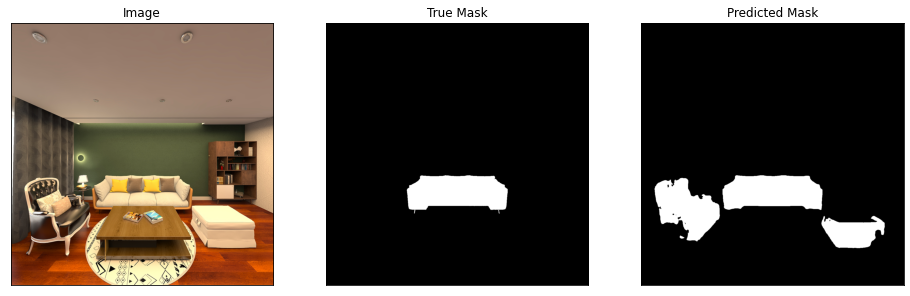

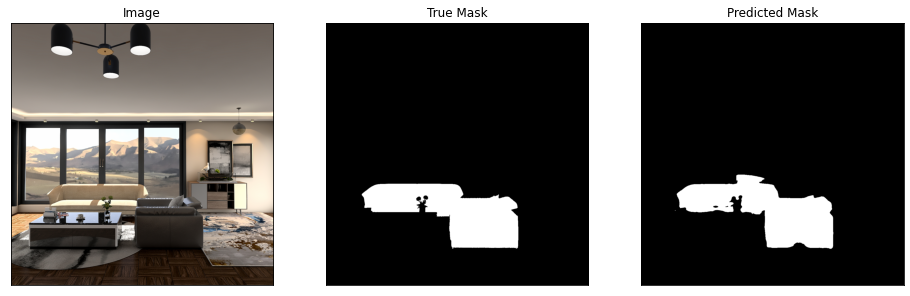

In [ ]:
import numpy as np 

# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

for i in [5, 6]:
    
  image, gt_mask = test_dataset[i]
  image = np.expand_dims(image, axis=0)
  pr_mask = model.predict(image).round()
  
  visualize(
      image=denormalize(image.squeeze()),
      true_mask=gt_mask[..., 0].squeeze(),
      predicted_mask=pr_mask[..., 0].squeeze(),
  )

# 4 Using style transfer - Customize your sofa

In this section, we will discover how to apply a style on top of a picture. If you remember, our ultimate goal is to apply a new style to a sofa on a virtual indoor space picture.

References: Y. Deng et al. "StyTr^2: Image Style Transfer with Transformers", IEEE Conference on Computer Vision and Pattern Recognition (CVPR), (2022). Github repository at https://github.com/diyiiyiii/StyTR-2

## 4.1 What is style transfer?

Style transfer is a computer vision technique that takes two images:
- a content image: the image with the content
- a style image: the image with the style/pattern to apply

The method then consists of blending these two images together so that the resulting output image retains the core elements of the content image, but appears to be "painted" in the style of the style image.

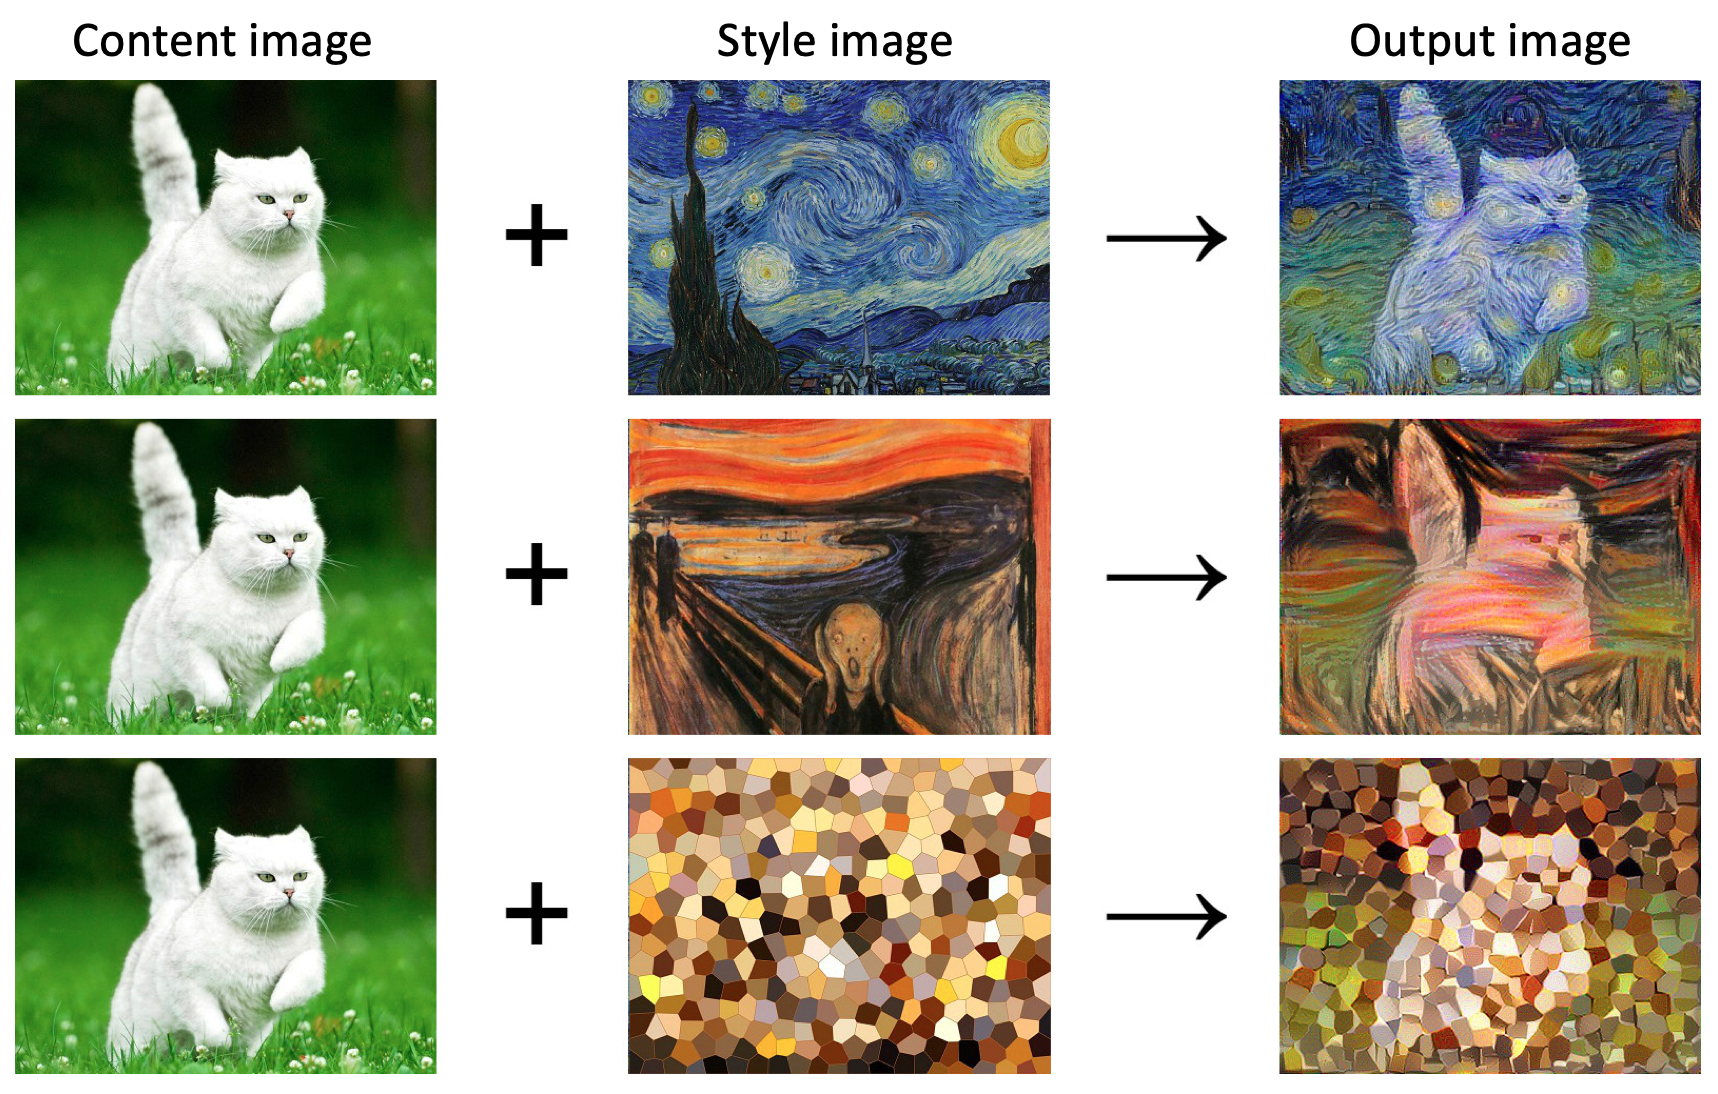

## 4.2 Choose the style to apply to our sofa

You can choose between 4 patterns that can be applied to the sofa, let's choose the one that you prefer!

In [ ]:
# Get style example from Azure 
import os

styles = {
    "multi-color": "examples/multicolor_pattern.jpeg",
    "tiger": "examples/tiger_pattern.jpeg",
    "water": "examples/water_pattern.jpeg",
    "zebra": "examples/zebra_pattern.jpeg",
}

style_path = os.path.join(DATA_DIR, styles["multi-color"])

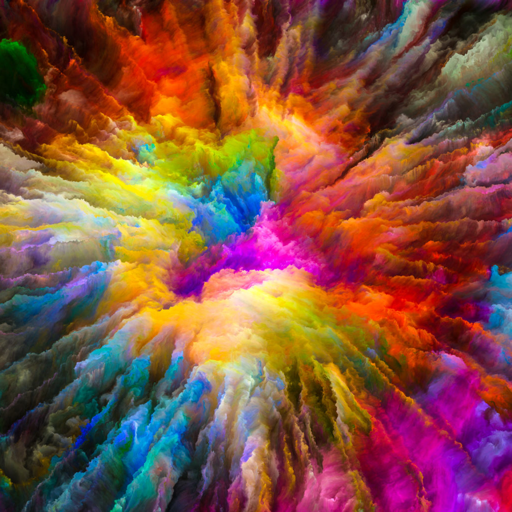

In [ ]:
from numpy.core.defchararray import upper
from PIL import Image
import numpy as np

img = Image.open(style_path)
width, height = img.size
idx = np.argmin([width,height])

if idx==0:
  top= (height-width)//2
  bottom= height-(height-width)//2
  left = 0
  right= width
else:
  left = (width-height)//2
  right = width - (width-height)//2
  top = 0
  bottom = height

newsize = (512, 512)
im1 = img.crop((left, top, right, bottom))
im1 = im1.resize(newsize)
display(im1)

We will transform the style that you chose into a nice pattern that can be applied to the sofa. 

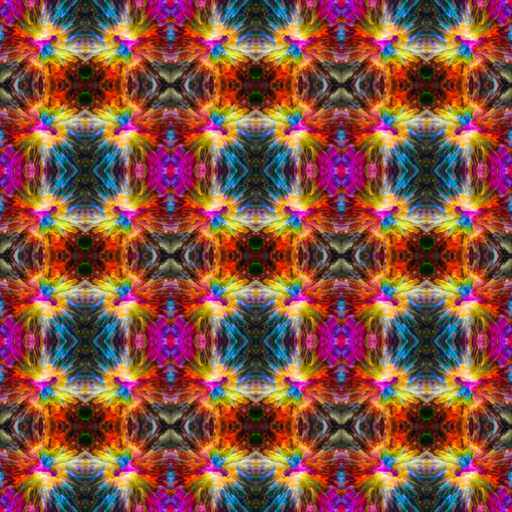

In [ ]:
copies = 6
resize = (newsize[0]//copies,newsize[1]//copies)
dst = Image.new('RGB', (resize[0]*copies,resize[1]*copies))
im2 = im1.resize((resize))
for row in range(copies):
  im2 = im2.transpose(Image.FLIP_LEFT_RIGHT)
  for column in range(copies):
    im2 = im2.transpose(Image.FLIP_TOP_BOTTOM)
    dst.paste(im2, (resize[0]*row, resize[1]*column))
dst = dst.resize((newsize))
dst.save('./style_zoomed_out.jpg')
display(dst)


## 4.3 Choose images on which to apply style transfer

Now that we chose the style to apply, we need to determine on which picture to apply this style. 

Let's first clone a GitHub repository containing the code that we will use to apply the style transfer. This style transfer technique is based on transformers. This means that we will run very complex model that are already pre-trained and that are very accurate.

In [ ]:
!git clone https://github.com/diyiiyiii/StyTR-2.git

Cloning into 'StyTR-2'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 83 (delta 10), reused 9 (delta 9), pack-reused 69
Unpacking objects: 100% (83/83), done.


In [ ]:
import torch
torch.cuda.device_count()
torch.cuda.get_device_name(0)

Let's choose the image on which we want to apply the new style and resize it

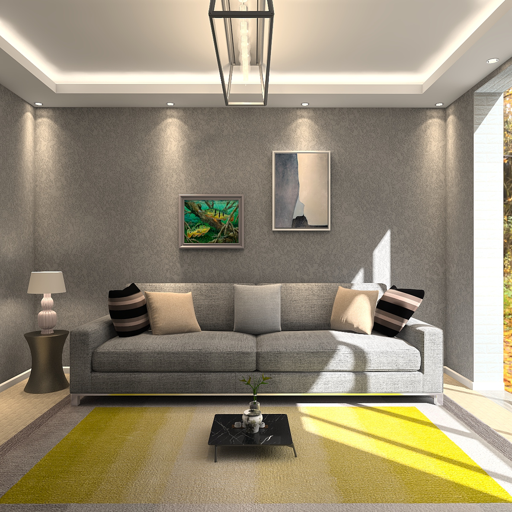

In [ ]:
from PIL import Image
import numpy as np

img, mask = original_dataset[2]
img = Image.fromarray(img)
width, height = img.size
idx = np.argmin([width,height])

if idx==0:
  img1 = Image.new(img.mode, (height, height), (255, 255, 255))
  img1.paste(img, ((height-width)//2, 0))
else:
  img1 = Image.new(img.mode, (width, width), (255, 255, 255))
  img1.paste(img, (0, (width-height)//2))

newsize = (512, 512) # parameters from test script
im1 = img1.resize(newsize)
display(im1)
im1.save('./sofa.jpg')

## 4.4 Apply the new style to our virtual indoor space image

In [ ]:
# Get pre-trained model from the cloud
import os 
vgg_path = os.path.join(DATA_DIR, "models/vgg_normalised.pth")
decoder_path = os.path.join(DATA_DIR, "models/decoder_iter_160000.pth")
transformer_path = os.path.join(DATA_DIR, "models/transformer_iter_160000.pth")
embedding_path = os.path.join(DATA_DIR, "models/embedding_iter_160000.pth")
vgg_path

'/tmp/tmpxntegl3p/models/vgg_normalised.pth'

In order to be able to run the *test.py* file properly, you need to open this file located at *StyTR-2/test.py* and change line 174 with the following code:

output = output[0].cpu()

Don't forget to save the new version of the file using CMD/CTRL + S.

In [ ]:
!python StyTR-2/test.py  --content sofa.jpg \
                  --style style_zoomed_out.jpg  \
                  --output  .\
                  --vgg $vgg_path \
                  --decoder_path $decoder_path \
                  --Trans_path $transformer_path \
                  --embedding_path $embedding_path

sofa.jpg
<class 'int'>
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


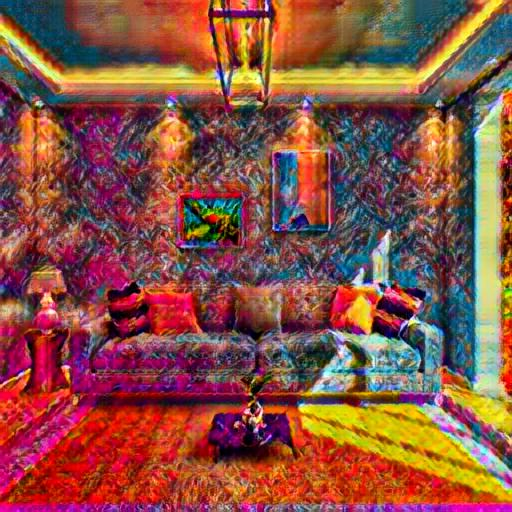

In [ ]:
# Let's look at the styled image
from IPython.display import Image, display
display(Image(filename="sofa_stylized_style_zoomed_out.jpg"))

# 5 Let's put everything together

On one hand, we have an image segmentation model that allows us to detect a sofa on a picture and that creates a mask of this sofa. On the other hand, we created a style transfer model that allows us to apply a style to an entire picture. The goal now is to put everything together to apply the style on the sofa only and not on the entire picture.

We retrieve the mask corresponding to the original picture that we chose before.

In [ ]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap='gray')
    plt.show()

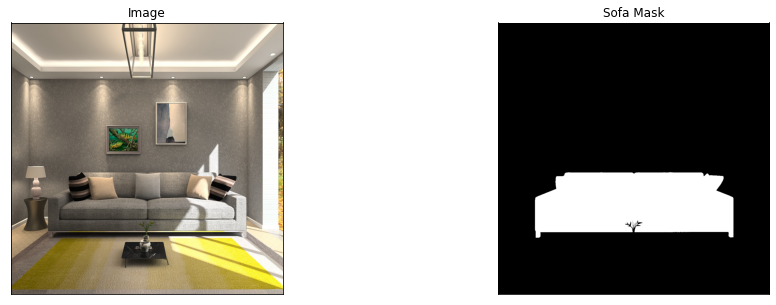

In [ ]:
from PIL import Image
import numpy as np
import imageio

img, mask = original_dataset[2]

visualize(
    image=img, 
    sofa_mask=mask[..., 0].squeeze(),
)

imageio.imwrite('mask.jpg', mask[..., 0].squeeze())


In [ ]:
!pip install -q 'scipy<=1.2.1' 

In [ ]:
dir_path = "Neural-Style-Transfer"
content_image = "sofa.jpg"
generated_image = "sofa_stylized_style_zoomed_out.jpg"
content_mask = "mask.jpg"

The following code can be used to apply the mask of an object to the styled image so that the final image will be similar to the original image except that the selected object will be styled.


**Acknoledgement**: The following code was inspired by this repo: https://github.com/titu1994/Neural-Style-Transfer.git

In [ ]:
import os
import numpy as np
import imageio
from PIL import Image as Img
from PIL import ImageTk

# util function to load masks
def load_mask(mask_path, shape):
    mask = imageio.imread(mask_path, pilmode="L") # Grayscale mask load
    width, height, _ = shape
    mask = np.array(Img.fromarray(mask).resize((width, height))).astype('float32')

    # Perform binarization of mask
    mask[mask <= 127] = 0
    mask[mask > 128] = 255

    max = np.amax(mask)
    mask /= max

    return mask


# util function to apply mask to generated image
def mask_content(content, generated, mask):
    width, height, channels = generated.shape

    for i in range(width):
        for j in range(height):
            if mask[i, j] == 0.:
                generated[i, j, :] = content[i, j, :]

    return generated

  
# util function to generate the final masked image
def save_final_masked(content_image, generated_image, content_mask):
  image_path = os.path.splitext(generated_image)[0] + "_masked.png"

  generated_image = imageio.imread(generated_image, pilmode="RGB")
  img_width, img_height, channels = generated_image.shape

  content_image = imageio.imread(content_image, pilmode='RGB')
  content_image = np.array(Img.fromarray(content_image).resize((img_width, img_height)))

  mask = load_mask(content_mask, generated_image.shape)

  img = mask_content(content_image, generated_image, mask)
  imageio.imwrite(image_path, img)

  return image_path


In [ ]:
save_image_path = save_final_masked(content_image, generated_image, content_mask)
print("Image saved at path : %s" % save_image_path)

Image saved at path : sofa_stylized_style_zoomed_out_masked.png


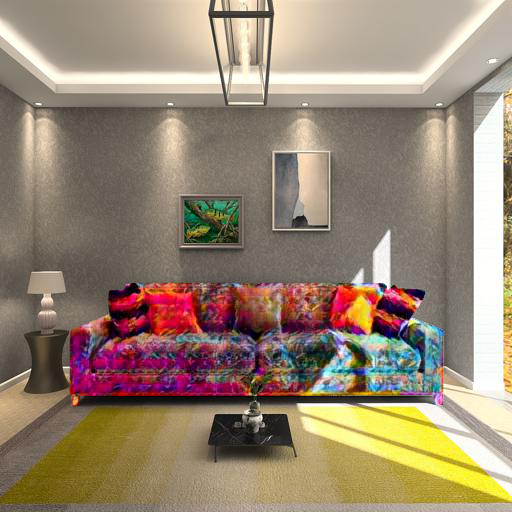

In [ ]:
# Let's look at the final styled image
from IPython.display import Image, display
display(Image(filename="sofa_stylized_style_zoomed_out_masked.png"))

# 6 Next steps: What could be improved?

In the previous sections, we discovered how to apply a style transfer to a particular object in an image. However, there are still some areas that can be improved.

## 6.1 In the image segmentation model

When evaluating the image segmentation model, we observed that the model struggled to differentiate between sofas and chairs. In some of the images, even a human would have difficulty identifying whether the object belongs to the sofa or chair category. This observation highlights the fact that a model is often biased by the data on which it is trained. It is therefore important to be aware of this bias and to try to minimise it. In our case, confusing a sofa with a chair is not dramatic. However, if this kind of bias appears in models representing the population, it can have serious consequences. Imagine a facial recognition model that is able to recognise men but not women, or people of European origin but not Asian. 

To solve this problem, we could train the model on more data and train it longer. However, this solution is very expensive in terms of resources and time. 

## 6.2 In the style transfer model

For the moment, the new style is applied to the whole image and it is the style transfer model that determines which objects in the image are most important, i.e. that will receive the most customization. This means that if we are working with an image in which the sofa is in the background, the model will only apply a small amount of styling to that object, as it is not highlighted. Ideally, we would like the style to always be applied to the sofa, no matter where it is positioned in the image. 

To solve this problem, we could apply the mask to the original image first to keep only the important object. This means that the style transfer model would only be able to highlight the really important object since there would only be that object in the picture. Then the stylized object would be copied and pasted onto the original image ignoring the rest of the image. 

In [ ]:
# Create black picture
from PIL import Image
image = Image.new('RGB', (512, 512), (255,255,255))
image = image.convert('RGBA')

newImage = []
for item in image.getdata():
    if item[:3] == (255, 255, 255):
        newImage.append((255, 255, 255, 0))
    else:
        newImage.append(item)

image.putdata(newImage)

image.save("transparent.png")

In [ ]:
content_image = "transparent.png"
generated_image = "sofa.jpg"
content_mask = "mask.jpg"

In [ ]:
save_image_path = save_final_masked(content_image, generated_image, content_mask)
print("Image saved at path : %s" % save_image_path)

Image saved at path : sofa_masked.png


In [ ]:
!python StyTR-2/test.py  --content sofa_masked.png \
                  --style style_zoomed_out.jpg  \
                  --output  .\
                  --vgg $vgg_path \
                  --decoder_path $decoder_path \
                  --Trans_path $transformer_path \
                  --embedding_path $embedding_path

sofa_masked.png
<class 'int'>
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


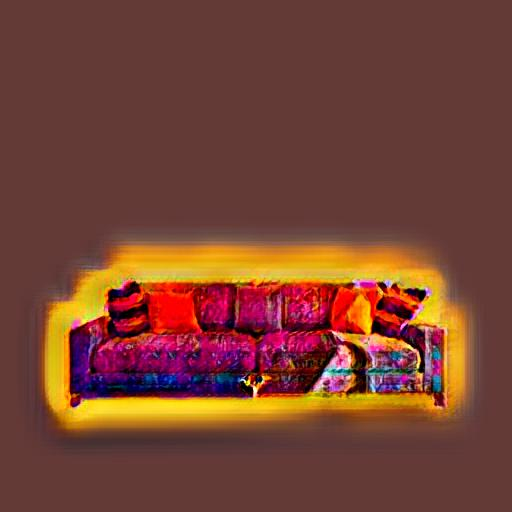

In [ ]:
# Let's look at the styled masked image
from IPython.display import Image, display
display(Image(filename="sofa_masked_stylized_style_zoomed_out.jpg"))

In [ ]:
content_image = "sofa.jpg"
generated_image = "sofa_masked_stylized_style_zoomed_out.jpg"
content_mask = "mask.jpg"

In [ ]:
save_image_path = save_final_masked(content_image, generated_image, content_mask)
print("Image saved at path : %s" % save_image_path)

Image saved at path : sofa_masked_stylized_style_zoomed_out_masked.png


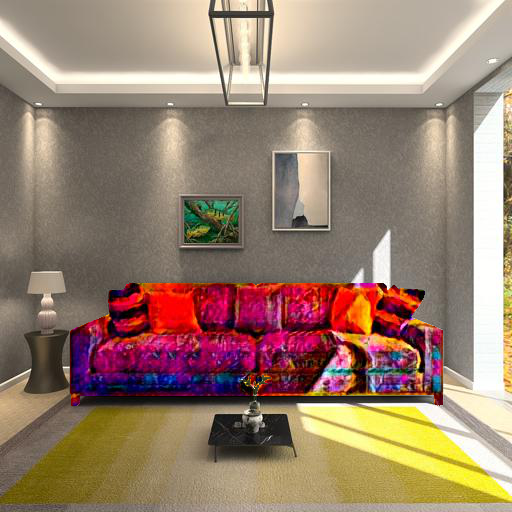

In [ ]:
# Let's look at the masked original image
from IPython.display import Image, display
display(Image(filename="sofa_masked_stylized_style_zoomed_out_masked.png"))